# Vertebral Bone Density & Age Estimation Analysis (Full Dataset)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr, f_oneway
from io import StringIO


In [3]:
# Add male dataset here


df_male = pd.read_csv(male.csv, sep='\t', names=["age", "density"])
df_female = pd.read_csv(female.csv, sep='\t', names=["age", "density"])
len(df_male), len(df_female)

NameError: name 'male' is not defined

In [4]:
def describe_data(df):
    return {
        'Mean Age': df['age'].mean(),
        'Std Age': df['age'].std(),
        'Median Age': df['age'].median(),
        'IQR Age': df['age'].quantile(0.75) - df['age'].quantile(0.25),
        'Min Age': df['age'].min(),
        'Max Age': df['age'].max()
    }

describe_data(df_male), describe_data(df_female)

({'Mean Age': np.float64(49.7196261682243),
  'Std Age': np.float64(17.827849377955285),
  'Median Age': np.float64(48.0),
  'IQR Age': np.float64(28.0),
  'Min Age': np.int64(20),
  'Max Age': np.int64(95)},
 {'Mean Age': np.float64(53.1219512195122),
  'Std Age': np.float64(18.189837193128724),
  'Median Age': np.float64(52.0),
  'IQR Age': np.float64(28.75),
  'Min Age': np.int64(20),
  'Max Age': np.int64(97)})

In [5]:
r_male, p_male = pearsonr(df_male['age'], df_male['density'])
r_female, p_female = pearsonr(df_female['age'], df_female['density'])

(f"Male: r = {r_male:.2f}, p = {p_male:.3f}", f"Female: r = {r_female:.2f}, p = {p_female:.3f}")

('Male: r = -0.75, p = 0.000', 'Female: r = -0.85, p = 0.000')

In [6]:
def anova_by_quartiles(df):
    df['quartile'] = pd.qcut(df['age'], 4, labels=False)
    groups = [df[df['quartile'] == i]['density'] for i in range(4)]
    f_stat, p_val = f_oneway(*groups)
    return f_stat, p_val

anova_by_quartiles(df_male), anova_by_quartiles(df_female)

((np.float64(154.85129069564772), np.float64(9.059356426721068e-68)),
 (np.float64(383.5666012347637), np.float64(4.518078505238698e-118)))

In [7]:
#random forest regression model

def train_rf_model(df):
    X = df[['density']]
    y = df['age']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R²': r2_score(y_test, y_pred)
    }

train_rf_model(df_male), train_rf_model(df_female)

({'MAE': 11.06900140460315,
  'MSE': 180.7314333909146,
  'RMSE': np.float64(13.443639142394241),
  'R²': 0.46708509148003163},
 {'MAE': 8.577608497870695,
  'MSE': 117.4244399154165,
  'RMSE': np.float64(10.836255807031158),
  'R²': 0.6531660516870488})

In [8]:
#Support Vector Regression (SVR)

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import joblib


    

def train_svr_model(df, sex):
    X = df[['density']]
    y = df['age']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Ölçekleme + SVR pipeline
    model = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=1, gamma=0.2, epsilon=0.1))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    joblib.dump(model, f"{sex}_age_density_SVR_model.pkl")

    return {
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R²': r2_score(y_test, y_pred)
    }

train_svr_model(df_male,"male"), train_svr_model(df_female,"female")





({'MAE': 10.059883110207707,
  'MSE': 153.00008435284852,
  'RMSE': np.float64(12.369320286614318),
  'R²': 0.5488553129544064},
 {'MAE': 8.610069894548374,
  'MSE': 109.05555937743797,
  'RMSE': np.float64(10.44296698153537),
  'R²': 0.6778850274133739})

In [9]:
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def build_model(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss=tf.keras.losses.Huber())
    return model

def run_kfold_cv(df, k=5):
    X = df[['density']].values
    y = df['age'].values

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    all_mae, all_rmse, all_r2 = [], [], []

    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}")
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = build_model(X.shape[1])
        model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

        y_pred = model.predict(X_test).flatten()

        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        all_mae.append(mae)
        all_rmse.append(rmse)
        all_r2.append(r2)

        print(f"MAE : {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

    print("\n🔍 Ortalama Sonuçlar ({}-Fold):".format(k))
    print(f"MAE  Ort: {np.mean(all_mae):.2f} ± {np.std(all_mae):.2f}")
    print(f"RMSE Ort: {np.mean(all_rmse):.2f} ± {np.std(all_rmse):.2f}")
    print(f"R²    Ort: {np.mean(all_r2):.2f} ± {np.std(all_r2):.2f}")

run_kfold_cv(df_female)
run_kfold_cv(df_male)




Fold 1
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
MAE : 7.75, RMSE: 9.46, R²: 0.74

Fold 2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
MAE : 7.67, RMSE: 9.17, R²: 0.72

Fold 3
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000023821556A20> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
MAE : 6.31, RMSE: 7.98, R²: 0.79


🟩 XGBoost - Kadın
Test MAE  : 8.14
Test RMSE : 10.12
Test R²   : 0.70



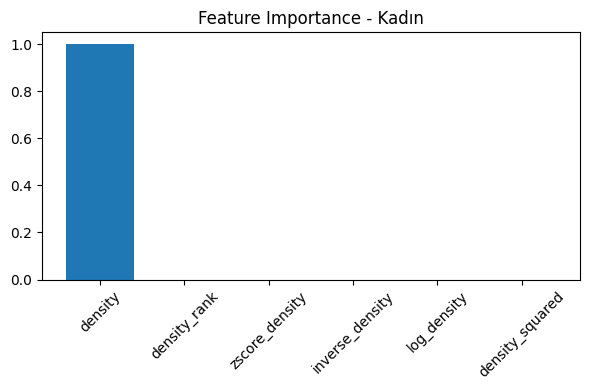

🟩 XGBoost - Erkek
Test MAE  : 9.74
Test RMSE : 11.91
Test R²   : 0.58



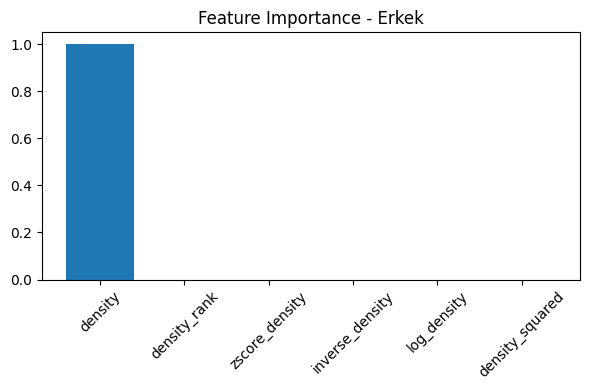

🧪 External Test - Erkek External
MAE  : 11.08
RMSE : 13.64
R²   : 0.55

🧪 External Test - Kadın External
MAE  : 6.37
RMSE : 7.92
R²   : 0.76



array([53.326607, 82.2726  , 43.37355 , 70.21274 , 34.177387, 67.57984 ,
       73.9179  , 70.21274 , 36.02339 , 72.067215, 77.36615 , 69.371315,
       70.24388 , 72.067215, 78.77332 , 63.217396, 72.067215, 75.62018 ,
       66.27855 , 57.97566 , 70.24388 , 75.62018 , 40.63536 , 66.00673 ,
       77.36615 , 73.9179  , 69.28549 , 81.51749 , 82.2726  , 70.24388 ,
       53.326607, 35.840187, 62.499203], dtype=float32)

In [10]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importance(model, feature_names, title=""):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(6, 4))
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), np.array(feature_names)[indices], rotation=45)
    plt.title(f"Feature Importance - {title}")
    plt.tight_layout()
    plt.show()

def add_engineered_features(df):
    df = df.copy()
    df['density_squared'] = df['density'] ** 2
    df['log_density'] = np.log1p(df['density'])  # log(1 + x)
    df['inverse_density'] = 1 / (df['density'] + 1e-5)
    df['zscore_density'] = (df['density'] - df['density'].mean()) / df['density'].std()
    df['density_rank'] = df['density'].rank(pct=True)
    return df

def train_xgboost_model(df, label=""):
    # Feature engineering
    df = add_engineered_features(df)

    # Özellik seti
    feature_cols = ['density', 'density_squared', 'log_density', 'inverse_density', 'zscore_density', 'density_rank']
    X = df[feature_cols].values
    y = df['age'].values

    # Ölçekleme (isteğe bağlı)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    # XGBoost model
    model = XGBRegressor(
        n_estimators=70,
        learning_rate=0.08,
        max_depth=4,
        random_state=42,
        objective='reg:squarederror'
    )

    model.fit(X_train, y_train)

    # Tahmin
    y_pred = model.predict(X_test)

    # Metrikler
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"🟩 XGBoost - {label}")
    print(f"Test MAE  : {mae:.2f}")
    print(f"Test RMSE : {rmse:.2f}")
    print(f"Test R²   : {r2:.2f}\n")

    return model, scaler

def test_external_dataset(external_df, model, scaler, label=""):
    # Aynı feature engineering uygulanmalı
    def add_engineered_features(df):
        df = df.copy()
        df['density_squared'] = df['density'] ** 2
        df['log_density'] = np.log1p(df['density'])
        df['inverse_density'] = 1 / (df['density'] + 1e-5)
        df['zscore_density'] = (df['density'] - df['density'].mean()) / df['density'].std()
        df['density_rank'] = df['density'].rank(pct=True)
        return df

    external_df = add_engineered_features(external_df)

    # Özellik isimleri aynı olmalı
    feature_cols = ['density', 'density_squared', 'log_density', 'inverse_density', 'zscore_density', 'density_rank']
    X_ext = external_df[feature_cols].values
    y_ext = external_df['age'].values

    # Ölçekleme
    X_ext_scaled = scaler.transform(X_ext)

    # Tahmin
    y_pred = model.predict(X_ext_scaled)

    # Metrikler
    mae = mean_absolute_error(y_ext, y_pred)
    mse = mean_squared_error(y_ext, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_ext, y_pred)

    print(f"🧪 External Test - {label}")
    print(f"MAE  : {mae:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"R²   : {r2:.2f}\n")

    return y_pred


feature_names = ['density', 'density_squared', 'log_density', 'inverse_density', 'zscore_density', 'density_rank']
model_female, scaler_female = train_xgboost_model(df_female, "Kadın")
plot_feature_importance(model_female, feature_names, "Kadın")

model_male, scaler_male = train_xgboost_model(df_male, "Erkek")
plot_feature_importance(model_male, feature_names, "Erkek")

test_external_dataset(df_maleTest, model=model_male, scaler=scaler_male, label="Erkek External")
test_external_dataset(df_femaleTest, model=model_female, scaler=scaler_female, label="Kadın External")



🟦 SGD - Kadın
MAE  : 29.36
RMSE : 33.72
R²   : -2.43



c:\Users\sipah\miniconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


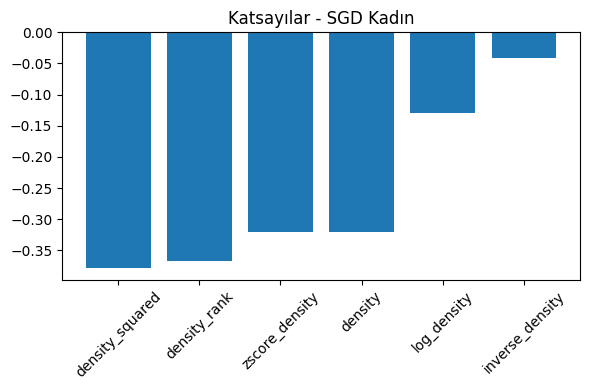

🟦 SGD - Erkek
MAE  : 22.06
RMSE : 27.03
R²   : -1.06



c:\Users\sipah\miniconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


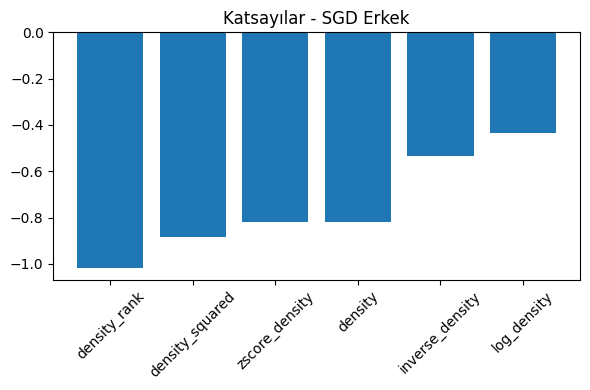

🧪 External Test - Kadın External (SGD)
MAE  : 40.47
RMSE : 43.24
R²   : -6.08

🧪 External Test - Erkek External (SGD)
MAE  : 32.02
RMSE : 36.74
R²   : -2.25

🟥 RANSAC(linear) - Kadın
MAE  : 7.73
RMSE : 9.41
R²   : 0.73



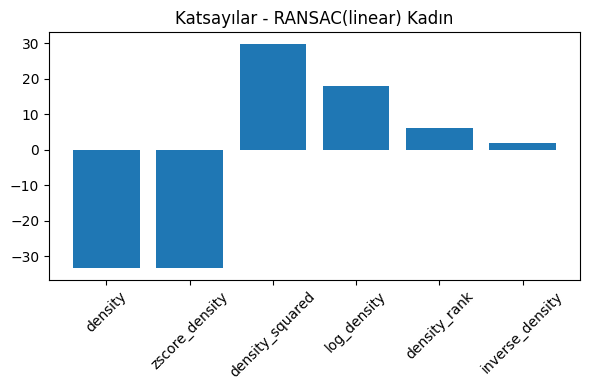

🟥 RANSAC(linear) - Erkek
MAE  : 10.36
RMSE : 12.66
R²   : 0.55



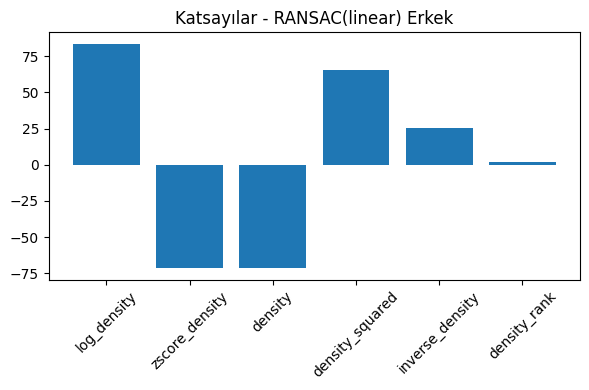

🧪 External Test - Kadın External (RANSAC-linear)
MAE  : 24.49
RMSE : 25.91
R²   : -1.54

🧪 External Test - Erkek External (RANSAC-linear)
MAE  : 63.51
RMSE : 65.43
R²   : -9.31



array([ -5.0403791 ,  11.77834669, -19.64174122,   7.8631539 ,
         4.25877936, 113.68406706, -27.2510717 ,  -4.93389052,
        -7.49283432,  11.44243971,  -1.04742061,  11.27216647,
       -21.1663517 , -30.41676269,  16.90458974, -14.64759143,
         4.22165702,   7.66164523,   7.43746001, -25.64641857])

In [11]:
from sklearn.linear_model import SGDRegressor, LinearRegression, HuberRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# --- Mevcut yardımcılar ---
def add_engineered_features(df):
    df = df.copy()
    df['density_squared'] = df['density'] ** 2
    df['log_density'] = np.log1p(df['density'])
    df['inverse_density'] = 1 / (df['density'] + 1e-5)
    df['zscore_density'] = (df['density'] - df['density'].mean()) / df['density'].std()
    df['density_rank'] = df['density'].rank(pct=True)
    return df

feature_cols = ['density', 'density_squared', 'log_density', 'inverse_density', 'zscore_density', 'density_rank']

def _metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

def _print_metrics(prefix, mae, rmse, r2):
    print(prefix)
    print(f"MAE  : {mae:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"R²   : {r2:.2f}\n")

def plot_coefficients(coefs, feature_names, title=""):
    order = np.argsort(np.abs(coefs))[::-1]
    coefs_sorted = np.array(coefs)[order]
    names_sorted = np.array(feature_names)[order]
    plt.figure(figsize=(6,4))
    plt.bar(range(len(coefs_sorted)), coefs_sorted)
    plt.xticks(range(len(coefs_sorted)), names_sorted, rotation=45)
    plt.title(f"Katsayılar - {title}")
    plt.tight_layout()
    plt.show()

# --- Ortak eğitim yardımcıları ---
def _prepare_xy(df):
    df_fe = add_engineered_features(df)
    X = df_fe[feature_cols].values
    y = df_fe['age'].values
    return X, y

def _split_scale(X, y, test_size=0.15, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test  = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test, scaler

# --- 1) SGD Regressor ---
def train_sgd_model(df, label=""):
    X, y = _prepare_xy(df)
    X_train, X_test, y_train, y_test, scaler = _split_scale(X, y)

    # Huber loss (robust) çoğu medikal veride iyi çalışır; istersen 'squared_error' da deneyebilirsin
    model = SGDRegressor(
        loss="huber",        # 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'
        penalty="l2",        # 'l1' ya da 'elasticnet' de denenebilir
        alpha=1e-3,          # düzenleme şiddeti
        l1_ratio=0.15,       # elasticnet için kullanılır
        max_iter=2000,
        tol=1e-3,
        early_stopping=True,
        validation_fraction=0.15,
        random_state=42
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae, rmse, r2 = _metrics(y_test, y_pred)
    _print_metrics(f"🟦 SGD - {label}", mae, rmse, r2)

    # Katsayı grafiği
    plot_coefficients(model.coef_, feature_cols, title=f"SGD {label}")

    return model, scaler

# --- 2) RANSAC Regressor ---
def train_ransac_model(df, label="", base="linear"):
    X, y = _prepare_xy(df)
    X_train, X_test, y_train, y_test, scaler = _split_scale(X, y)

    # Taban tahminci: LinearRegression (klasik) veya HuberRegressor (ekstra robustluk)
    if base == "huber":
        base_est = HuberRegressor(alpha=0.0001, epsilon=1.35)
    else:
        base_est = LinearRegression()

    model = RANSACRegressor(
        estimator=base_est,      # sklearn>=1.2 için 'estimator'
        min_samples=0.5,         # veri oranı veya tamsayı
        residual_threshold=None, # None -> MAD tabanlı otomatik eşik
        max_trials=1000,
        random_state=42
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae, rmse, r2 = _metrics(y_test, y_pred)
    _print_metrics(f"🟥 RANSAC({base}) - {label}", mae, rmse, r2)

    # Katsayı grafiği (estimator_ üzerinden)
    est = model.estimator_
    if hasattr(est, "coef_"):
        plot_coefficients(est.coef_, feature_cols, title=f"RANSAC({base}) {label}")

    return model, scaler

# --- External test (SGD ve RANSAC ile uyumlu) ---
def test_external_dataset_generic(external_df, model, scaler, label=""):
    df_fe = add_engineered_features(external_df)
    X_ext = df_fe[feature_cols].values
    y_ext = df_fe['age'].values
    X_ext_scaled = scaler.transform(X_ext)

    y_pred = model.predict(X_ext_scaled)
    mae, rmse, r2 = _metrics(y_ext, y_pred)
    _print_metrics(f"🧪 External Test - {label}", mae, rmse, r2)
    return y_pred

# --- ÖRNEK KULLANIM ---
# SGD
sgd_female, sc_female_sgd = train_sgd_model(df_female, "Kadın")
sgd_male,   sc_male_sgd   = train_sgd_model(df_male,   "Erkek")

test_external_dataset_generic(df_femaleTest, sgd_female, sc_female_sgd, "Kadın External (SGD)")
test_external_dataset_generic(df_maleTest,   sgd_male,   sc_male_sgd,   "Erkek External (SGD)")

# RANSAC (Linear tabanlı)
ransac_female_lin, sc_female_ransac_lin = train_ransac_model(df_female, "Kadın", base="linear")
ransac_male_lin,   sc_male_ransac_lin   = train_ransac_model(df_male,   "Erkek", base="linear")

test_external_dataset_generic(df_femaleTest, ransac_female_lin, sc_female_ransac_lin, "Kadın External (RANSAC-linear)")
test_external_dataset_generic(df_maleTest,   ransac_male_lin,   sc_male_ransac_lin,   "Erkek External (RANSAC-linear)")

# İstersen RANSAC + Huber tabanlı da deneyebilirsin:
# ransac_female_hub, sc_female_ransac_hub = train_ransac_model(df_female, "Kadın", base="huber")
# ransac_male_hub,   sc_male_ransac_hub   = train_ransac_model(df_male,   "Erkek", base="huber")
# test_external_dataset_generic(df_femaleTest, ransac_female_hub, sc_female_ransac_hub, "Kadın External (RANSAC-huber)")
# test_external_dataset_generic(df_maleTest,   ransac_male_hub,   sc_male_ransac_hub,   "Erkek External (RANSAC-huber)")


🟪 LassoCV (cv=5) - Kadın
MAE  : 7.73
RMSE : 9.40
R²   : 0.73



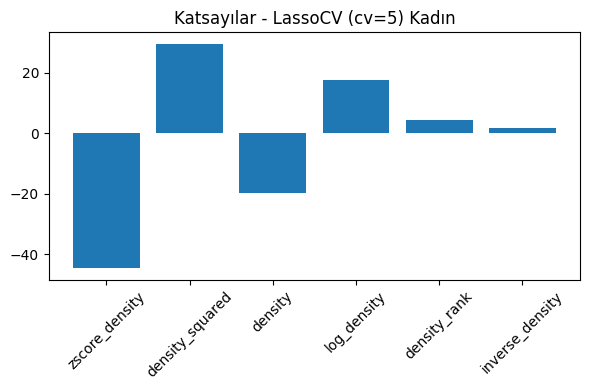

c:\Users\sipah\miniconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.435e+02, tolerance: 9.365e+00
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\sipah\miniconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.891e+03, tolerance: 9.365e+00
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\sipah\miniconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.903e

🟪 LassoCV (cv=5) - Erkek
MAE  : 10.25
RMSE : 12.55
R²   : 0.56



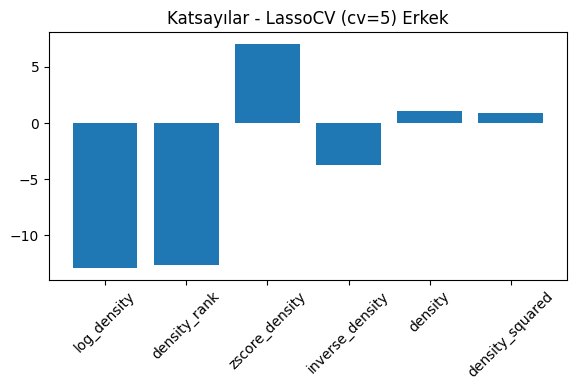

🧪 External Test - Kadın External (Lasso)
MAE  : 34.86
RMSE : 35.90
R²   : -3.88

🧪 External Test - Erkek External (Lasso)
MAE  : 12.03
RMSE : 14.84
R²   : 0.47

🟪 LassoCV (cv=5) - Kadın
MAE  : 7.73
RMSE : 9.40
R²   : 0.73



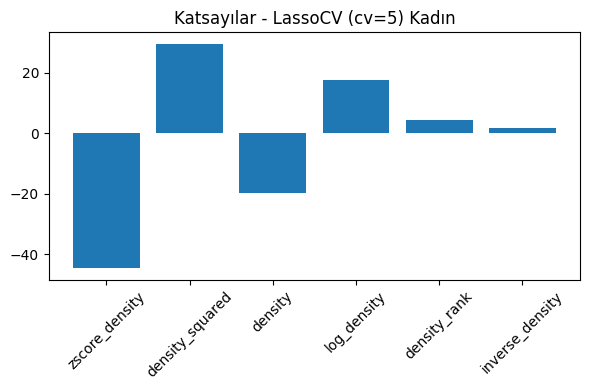

c:\Users\sipah\miniconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.435e+02, tolerance: 9.365e+00
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\sipah\miniconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.891e+03, tolerance: 9.365e+00
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\sipah\miniconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.903e

🟪 LassoCV (cv=5) - Erkek
MAE  : 10.25
RMSE : 12.55
R²   : 0.56



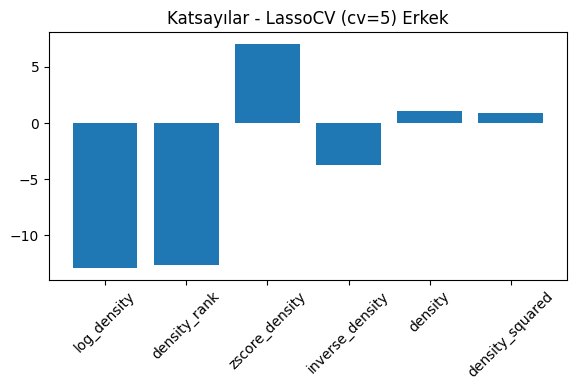

🧪 External Test - Kadın External (LassoCV)
MAE  : 34.86
RMSE : 35.90
R²   : -3.88

🧪 External Test - Erkek External (LassoCV)
MAE  : 12.03
RMSE : 14.84
R²   : 0.47



array([48.74991603, 79.01243895, 41.45376222, 67.61231757, 59.37039064,
       76.37933598, 35.24681263, 50.97426214, 46.30055428, 73.21632945,
       53.73255587, 75.5712169 , 39.29704449, 33.40271935, 83.83832922,
       43.69589356, 57.10054546, 65.18998046, 62.77630342, 37.29973021])

In [12]:
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# --- Gerekirse yardımcıları tanımla ---
try:
    add_engineered_features
except NameError:
    def add_engineered_features(df):
        df = df.copy()
        df['density_squared'] = df['density'] ** 2
        df['log_density'] = np.log1p(df['density'])
        df['inverse_density'] = 1 / (df['density'] + 1e-5)
        df['zscore_density'] = (df['density'] - df['density'].mean()) / df['density'].std()
        df['density_rank'] = df['density'].rank(pct=True)
        return df

feature_cols = ['density', 'density_squared', 'log_density', 'inverse_density', 'zscore_density', 'density_rank']

def _metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

def _print_metrics(prefix, mae, rmse, r2):
    print(prefix)
    print(f"MAE  : {mae:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"R²   : {r2:.2f}\n")

def plot_coefficients(coefs, feature_names, title=""):
    order = np.argsort(np.abs(coefs))[::-1]
    coefs_sorted = np.array(coefs)[order]
    names_sorted = np.array(feature_names)[order]
    plt.figure(figsize=(6,4))
    plt.bar(range(len(coefs_sorted)), coefs_sorted)
    plt.xticks(range(len(coefs_sorted)), names_sorted, rotation=45)
    plt.title(f"Katsayılar - {title}")
    plt.tight_layout()
    plt.show()

def _prepare_xy(df):
    df_fe = add_engineered_features(df)
    X = df_fe[feature_cols].values
    y = df_fe['age'].values
    return X, y

def _split_scale(X, y, test_size=0.15, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test  = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test, scaler

# --- LASSO ---
def train_lasso_model(df, label="", alpha=0.01, use_cv=False, cv=5, random_state=42, max_iter=10000):
    """
    use_cv=True -> LassoCV ile alpha seçimi (logspace taraması).
    use_cv=False -> verilen alpha değeriyle Lasso.
    """
    use_cv=True
    X, y = _prepare_xy(df)
    X_train, X_test, y_train, y_test, scaler = _split_scale(X, y)

    if use_cv:
        alphas = np.logspace(-4, 1, 50)
        model = LassoCV(alphas=alphas, cv=cv, random_state=random_state, max_iter=max_iter)
    else:
        model = Lasso(alpha=alpha, random_state=random_state, max_iter=max_iter)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae, rmse, r2 = _metrics(y_test, y_pred)

    tag = f"LassoCV (cv={cv})" if use_cv else f"Lasso (alpha={getattr(model, 'alpha_', alpha):.4f})"
    _print_metrics(f"🟪 {tag} - {label}", mae, rmse, r2)

    # Katsayı grafiği
    plot_coefficients(model.coef_, feature_cols, title=f"{tag} {label}")

    return model, scaler

# --- External test (Lasso ile uyumlu) ---
def test_external_dataset_generic(external_df, model, scaler, label=""):
    df_fe = add_engineered_features(external_df)
    X_ext = df_fe[feature_cols].values
    y_ext = df_fe['age'].values
    X_ext_scaled = scaler.transform(X_ext)
    y_pred = model.predict(X_ext_scaled)
    mae, rmse, r2 = _metrics(y_ext, y_pred)
    _print_metrics(f"🧪 External Test - {label}", mae, rmse, r2)
    return y_pred

# --- ÖRNEK KULLANIM ---
# Sabit alpha ile:
lasso_female, sc_female_lasso = train_lasso_model(df_female, "Kadın", alpha=0.01, use_cv=False)
lasso_male,   sc_male_lasso   = train_lasso_model(df_male,   "Erkek", alpha=0.01, use_cv=False)

test_external_dataset_generic(df_femaleTest, lasso_female, sc_female_lasso, "Kadın External (Lasso)")
test_external_dataset_generic(df_maleTest,   lasso_male,   sc_male_lasso,   "Erkek External (Lasso)")

# Otomatik alpha seçimi (LassoCV) ile:
lassocv_female, sc_female_lassocv = train_lasso_model(df_female, "Kadın", use_cv=True, cv=5)
lassocv_male,   sc_male_lassocv   = train_lasso_model(df_male,   "Erkek", use_cv=True, cv=5)

test_external_dataset_generic(df_femaleTest, lassocv_female, sc_female_lassocv, "Kadın External (LassoCV)")
test_external_dataset_generic(df_maleTest,   lassocv_male,   sc_male_lassocv,   "Erkek External (LassoCV)")


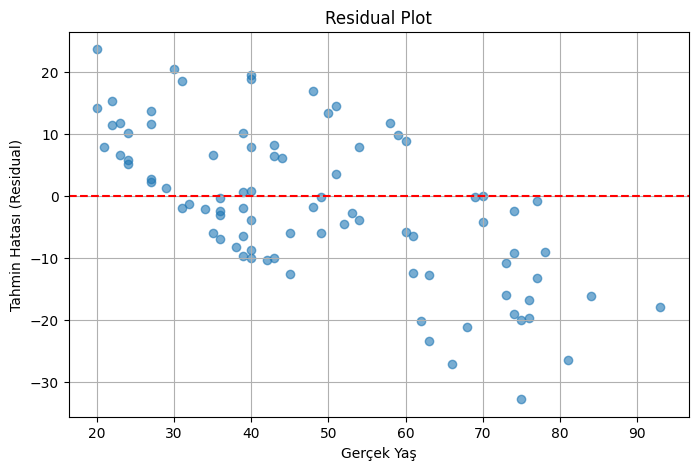

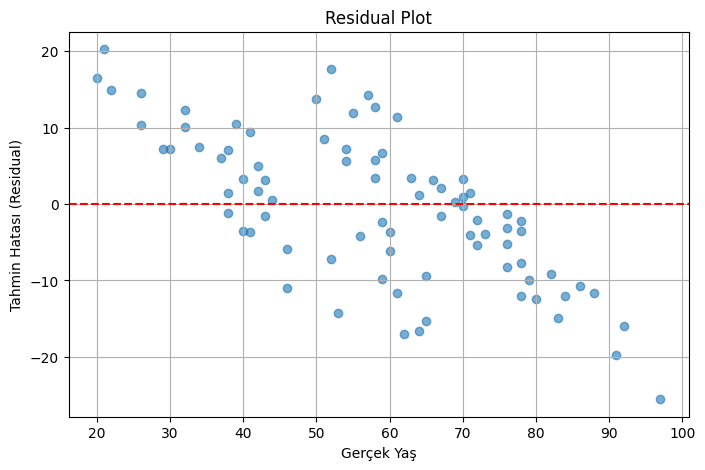

In [13]:

import matplotlib.pyplot as plt

def plot_residuals(model, df):
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    X = df[['density']]
    y = df['age']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    residuals = y_pred - y_test

    # Grafik
    plt.figure(figsize=(8, 5))
    plt.scatter(y_test, residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Gerçek Yaş")
    plt.ylabel("Tahmin Hatası (Residual)")
    plt.title("Residual Plot")
    plt.grid(True)
    plt.show()

svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
plot_residuals(svr_model, df_male)
plot_residuals(svr_model, df_female)

c:\Users\sipah\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:03:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.40      0.34        15
           1       0.40      0.35      0.38        17
           2       0.50      0.28      0.36        18
           3       0.22      0.22      0.22         9
           4       0.15      0.20      0.17        10
           5       0.40      0.29      0.33        14
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         1

    accuracy                           0.29        86
   macro avg       0.25      0.22      0.23        86
weighted avg       0.34      0.29      0.31        86

Confusion Matrix:
[[6 6 1 1 1 0 0 0]
 [8 6 2 0 1 0 0 0]
 [4 3 5 2 3 1 0 0]
 [0 0 1 2 2 2 1 1]
 [2 0 0 3 2 1 0 2]
 [0 0 1 1 3 4 4 1]
 [0 0 0 0 1 1 0 0]
 [0 0 0 0 0 1 0 0]]


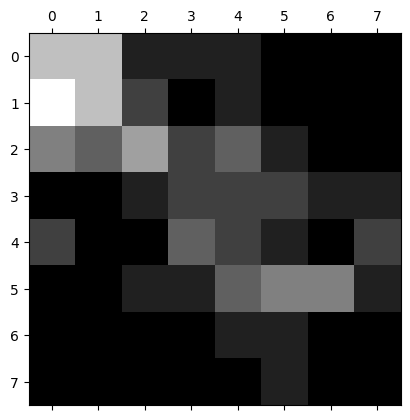

c:\Users\sipah\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:03:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
              precision    recall  f1-score   support

           0       0.18      0.33      0.24         6
           1       0.40      0.22      0.29         9
           2       0.50      0.36      0.42        11
           3       0.27      0.25      0.26        16
           4       0.22      0.14      0.17        14
           5       0.43      0.35      0.39        17
           6       0.21      0.67      0.32         6
           7       1.00      0.33      0.50         3

    accuracy                           0.30        82
   macro avg       0.40      0.33      0.32        82
weighted avg       0.36      0.30      0.31        82

Confusion Matrix:
[[2 1 3 0 0 0 0 0]
 [4 2 1 1 1 0 0 0]
 [3 2 4 2 0 0 0 0]
 [1 0 0 4 4 2 5 0]
 [1 0 0 5 2 5 1 0]
 [0 0 0 2 2 6 7 0]
 [0 0 0 1 0 1 4 0]
 [0 0 0 0 0 0 2 1]]


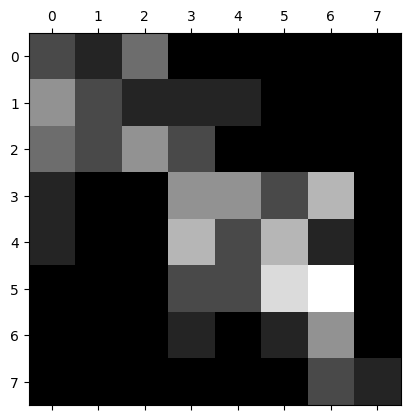

In [14]:

def label_age_groups_20plus(df):
    df = df[df['age'] >= 20].copy()
    df['age_group'] = ((df['age'] - 20) // 10).astype(int)
    return df

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight

def train_and_evaluate_classifier(df, model, use_class_weight=False, use_proba=False):
    df = label_age_groups_20plus(df)
    X = df[['density']]
    y = df['age_group']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if use_class_weight:
        sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
        model.fit(X_train, y_train, sample_weight=sample_weights)
    else:
        model.fit(X_train, y_train)

    if use_proba and hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)
        y_pred = y_pred_proba.argmax(axis=1)  
    else:
        y_pred = model.predict(X_test)

    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    plt.matshow(confusion_matrix(y_test, y_pred), cmap=plt.cm.gray)
    plt.show()
    return model

from xgboost import XGBClassifier

xgb_model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss')
trained_xgb = train_and_evaluate_classifier(df_male, xgb_model, use_class_weight=True, use_proba=True)


xgb_model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss')
trained_xgb = train_and_evaluate_classifier(df_female, xgb_model, use_class_weight=True, use_proba=True)

In [15]:
from scipy.stats import iqr

def summarize_age(df):
    n = df['age'].count() 
    mean_age = df['age'].mean()
    std_age = df['age'].std()
    median_age = df['age'].median()
    q1 = df['age'].quantile(0.25)
    q3 = df['age'].quantile(0.75)
    min_age = df['age'].min()
    max_age = df['age'].max()

    return {
        'N': n,
        'Mean Age (±SD)': f"{mean_age:.1f} ± {std_age:.1f}",
        'Median Age (IQR)': f"{median_age:.0f} ({int(q1)}–{int(q3)})",
        'Min–Max Age': f"{int(min_age)}–{int(max_age)}"
    }


summary_male = summarize_age(df_male)
summary_female = summarize_age(df_female)


summary_df = pd.DataFrame([summary_male, summary_female], index=['Male', 'Female'])


import matplotlib.pyplot as plt
import pandas.plotting as pd_plotting
from IPython.display import display

display(summary_df)


,N,Mean Age (±SD),Median Age (IQR),Min–Max Age
Male,428,49.7 ± 17.8,48 (36–64),20–95
Female,410,53.1 ± 18.2,52 (39–67),20–97


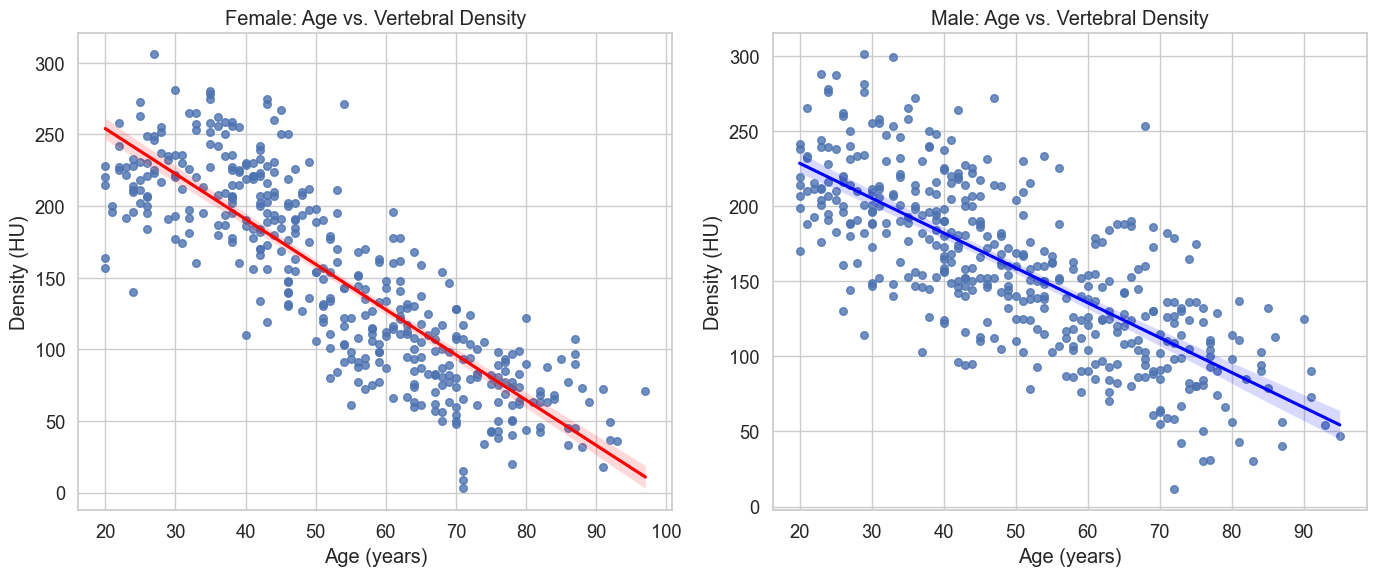

In [ ]:

# Correlation plots to visualize the relationship between age and bone density.
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(14, 6))

# Female
plt.subplot(1, 2, 1)
sns.regplot(x="age", y="density", data=df_female, scatter_kws={"s": 30}, line_kws={"color": "red"})
plt.title("Female: Age vs. Vertebral Density")
plt.xlabel("Age (years)")
plt.ylabel("Density (HU)")

# Male
plt.subplot(1, 2, 2)
sns.regplot(x="age", y="density", data=df_male, scatter_kws={"s": 30}, line_kws={"color": "blue"})
plt.title("Male: Age vs. Vertebral Density")
plt.xlabel("Age (years)")
plt.ylabel("Density (HU)")

plt.tight_layout()
plt.savefig("correlation.png", dpi=300)
plt.show()


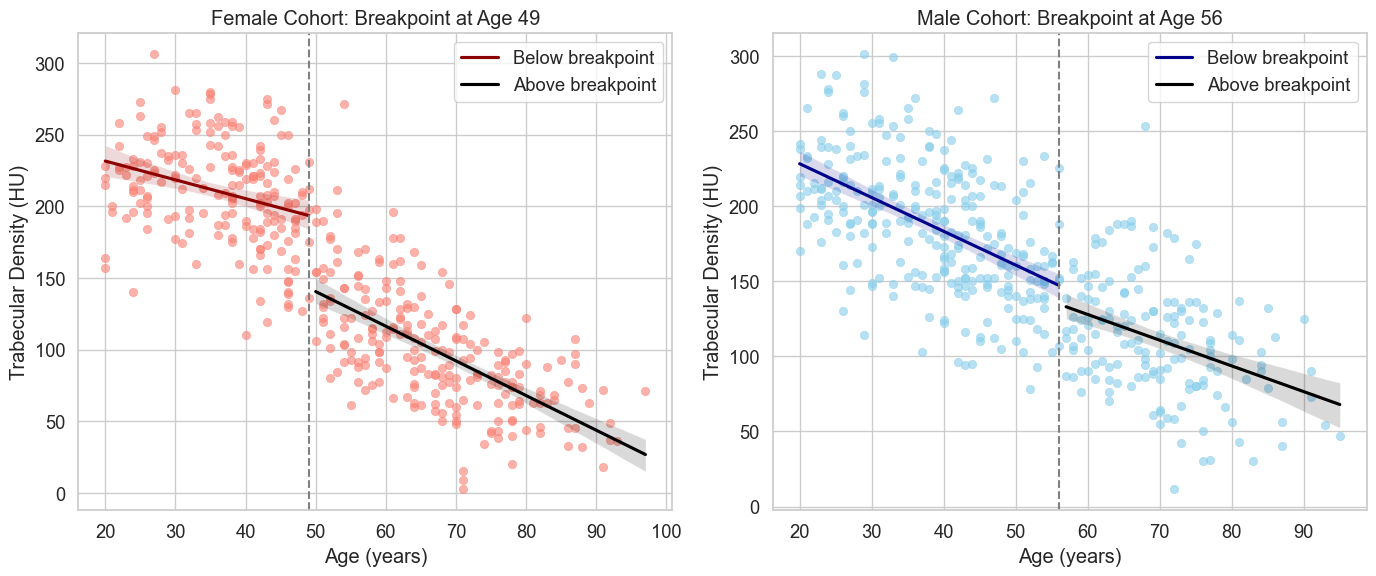

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Breakpoint function working over age
def find_breakpoint(df, min_age=30, max_age=80):
    ages = range(min_age, max_age + 1)
    errors = []

    for breakpoint in ages:
        df_low = df[df["age"] <= breakpoint]
        df_high = df[df["age"] > breakpoint]

        if len(df_low) < 10 or len(df_high) < 10:
            errors.append(float('inf'))
            continue

        X_low = sm.add_constant(df_low["age"])
        X_high = sm.add_constant(df_high["age"])
        y_low = df_low["density"]
        y_high = df_high["density"]

        model_low = sm.OLS(y_low, X_low).fit()
        model_high = sm.OLS(y_high, X_high).fit()

        error = model_low.ssr + model_high.ssr
        errors.append(error)

    best_index = int(errors.index(min(errors)))
    best_age = ages[best_index]
    return best_age, errors[best_index]

# Breakpoints for both cohorts
best_female_age, _ = find_breakpoint(df_female)
best_male_age, _ = find_breakpoint(df_male)

# Create scatter plots with regression lines
sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(14, 6))

# Female
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_female, x="age", y="density", alpha=0.6, color="salmon", edgecolor=None)
sns.regplot(data=df_female[df_female["age"] <= best_female_age], x="age", y="density", scatter=False, color="darkred", label="Below breakpoint")
sns.regplot(data=df_female[df_female["age"] > best_female_age], x="age", y="density", scatter=False, color="black", label="Above breakpoint")
plt.axvline(x=best_female_age, color="gray", linestyle="--")
plt.title(f"Female Cohort: Breakpoint at Age {best_female_age}")
plt.xlabel("Age (years)")
plt.ylabel("Trabecular Density (HU)")
plt.legend()

# Male
plt.subplot(1, 2, 2)
sns.scatterplot(data=df_male, x="age", y="density", alpha=0.6, color="skyblue", edgecolor=None)
sns.regplot(data=df_male[df_male["age"] <= best_male_age], x="age", y="density", scatter=False, color="darkblue", label="Below breakpoint")
sns.regplot(data=df_male[df_male["age"] > best_male_age], x="age", y="density", scatter=False, color="black", label="Above breakpoint")
plt.axvline(x=best_male_age, color="gray", linestyle="--")
plt.title(f"Male Cohort: Breakpoint at Age {best_male_age}")
plt.xlabel("Age (years)")
plt.ylabel("Trabecular Density (HU)")
plt.legend()

plt.tight_layout()
plt.savefig("breakpoints_graph.png", dpi=300)
plt.show()


In [ ]:

# Table comparing slope differences and statistical significance
from scipy.stats import linregress, ttest_ind_from_stats
import pandas as pd

def slope_test(df, label):
    under = df[df["age"] < 50]
    over = df[df["age"] >= 50]

    slope_u, _, _, _, stderr_u = linregress(under["age"], under["density"])
    slope_o, _, _, _, stderr_o = linregress(over["age"], over["density"])

    t_stat, p_val = ttest_ind_from_stats(
        mean1=slope_o, std1=stderr_o, nobs1=len(over),
        mean2=slope_u, std2=stderr_u, nobs2=len(under)
    )

    return {
        "Group": label,
        "Slope <50": round(slope_u, 2),
        "Slope ≥50": round(slope_o, 2),
        "Δ Slope": round(slope_o - slope_u, 2),
        "p-value": f"{p_val:.1e}"
    }

# Create table for slopes
slope_table = pd.DataFrame([
    slope_test(df_female, "Female"),
    slope_test(df_male, "Male")
])

slope_table


,Group,Slope <50,Slope ≥50,Δ Slope,p-value
0,Female,-1.31,-2.42,-1.11,1.9e-158
1,Male,-2.20,-2.06,0.14,2.1e-07


In [ ]:
# logistik regression model for classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Male breakpoint: 39 years for our dataset
df_male['label'] = df_male['age'].apply(lambda x: 1 if x >= 39 else 0)
X_male = df_male[['density']]
y_male = df_male['label']
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_male, y_male, test_size=0.3, random_state=42)
model_male = LogisticRegression()
model_male.fit(X_train_m, y_train_m)
y_pred_m = model_male.predict(X_test_m)
print("Male Classification Report:")
print(classification_report(y_test_m, y_pred_m))
print("Accuracy (Male):", accuracy_score(y_test_m, y_pred_m))

# Female breakpoint: 50 years for our dataset
df_female['label'] = df_female['age'].apply(lambda x: 1 if x >= 50 else 0)
X_female = df_female[['density']]
y_female = df_female['label']
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_female, y_female, test_size=0.3, random_state=42)
model_female = LogisticRegression()
model_female.fit(X_train_f, y_train_f)
y_pred_f = model_female.predict(X_test_f)
print("Female Classification Report:")
print(classification_report(y_test_f, y_pred_f))
print("Accuracy (Female):", accuracy_score(y_test_f, y_pred_f))


Male Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.72      0.72        40
           1       0.88      0.88      0.88        89

    accuracy                           0.83       129
   macro avg       0.80      0.80      0.80       129
weighted avg       0.83      0.83      0.83       129

Accuracy (Male): 0.8294573643410853
Female Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.93      0.87        43
           1       0.96      0.89      0.92        80

    accuracy                           0.90       123
   macro avg       0.89      0.91      0.90       123
weighted avg       0.91      0.90      0.90       123

Accuracy (Female): 0.9024390243902439
